# Task 1: Exploratory Data Analysis (EDA)

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# Connecting to databases
weather_conn = sqlite3.connect('data/weather.db')
weather_df = pd.read_sql_query("SELECT * FROM weather", weather_conn)

air_quality_conn = sqlite3.connect('data/air_quality.db')
air_quality_df = pd.read_sql_query("SELECT * FROM air_quality", air_quality_conn)

weather_conn.close()
air_quality_conn.close()

# Configure sns settings
sns.set(style="whitegrid")

## Data Cleaning

### Ensure data is in the correct data types

Several numerical columns are incorrectly categorized as object (e.g., wind speed, temperatures, etc.). We need to convert these columns to their proper data types to perform calculations and statistical analysis on them.


In [2]:
# Check dataset's types
print("Weather data info")
print(weather_df.info())

print("\nAir quality data info")
print(air_quality_df.info())

Weather data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3517 entries, 0 to 3516
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   data_ref                       3517 non-null   object 
 1   date                           3517 non-null   object 
 2   Daily Rainfall Total (mm)      3517 non-null   object 
 3   Highest 30 Min Rainfall (mm)   3517 non-null   object 
 4   Highest 60 Min Rainfall (mm)   3517 non-null   object 
 5   Highest 120 Min Rainfall (mm)  3517 non-null   object 
 6   Min Temperature (deg C)        3517 non-null   object 
 7   Maximum Temperature (deg C)    3517 non-null   object 
 8   Min Wind Speed (km/h)          3517 non-null   object 
 9   Max Wind Speed (km/h)          3502 non-null   object 
 10  Sunshine Duration (hrs)        3501 non-null   float64
 11  Cloud Cover (%)                3501 non-null   float64
 12  Wet Bulb Temperature (deg F)  

In [3]:
# Convert columns to numeric data types (ignore errors for non-numeric values)
def to_numeric(df, *cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

to_numeric(weather_df,
           'Min Wind Speed (km/h)',
           'Max Wind Speed (km/h)',
           'Min Temperature (deg C)',
           'Maximum Temperature (deg C)',
           'Daily Rainfall Total (mm)',
           'Highest 30 Min Rainfall (mm)',
           'Highest 60 Min Rainfall (mm)',
           'Highest 120 Min Rainfall (mm)'
          )

to_numeric(air_quality_df,
           'pm25_north',
           'pm25_south',
           'pm25_east',
           'pm25_west',
           'pm25_central',
           'psi_north',
           'psi_south',
           'psi_east',
           'psi_west',
           'psi_central'
          )

# Verifying the data types
print(f"Weather data data types:\n{weather_df.dtypes}")
print(f"\nAir quality data data types:\n{air_quality_df.dtypes}")

Weather data data types:
data_ref                          object
date                              object
Daily Rainfall Total (mm)        float64
Highest 30 Min Rainfall (mm)     float64
Highest 60 Min Rainfall (mm)     float64
Highest 120 Min Rainfall (mm)    float64
Min Temperature (deg C)          float64
Maximum Temperature (deg C)      float64
Min Wind Speed (km/h)            float64
Max Wind Speed (km/h)            float64
Sunshine Duration (hrs)          float64
Cloud Cover (%)                  float64
Wet Bulb Temperature (deg F)     float64
Relative Humidity (%)            float64
Air Pressure (hPa)                 int64
Dew Point Category                object
Wind Direction                    object
Daily Solar Panel Efficiency      object
dtype: object

Air quality data data types:
data_ref         object
date             object
pm25_north      float64
pm25_south      float64
pm25_east       float64
pm25_west       float64
pm25_central    float64
psi_north       float64
p

### Check for missing values in datasets
Upon checking for missing values, the weather dataset contains a few missing values:
- 'Max Wind Speed' (15 missing values)
- 'Sunshine Duration (hrs)' (16 missing values)
- 'Cloud Cover' (16 missing values)

Given that these features may influence solar panel efficiency (e.g., cloud cover affecting sunlight), these missing values should be handled appropriately—either by imputing them (e.g., with the mean or median) or removing the rows. In this case, I have chosen to remove them, assuming that the NA values are random.

In the air quality dataset, there is a consistent 39 missing values across several columns (PM25 and PSI for various regions). This consistent pattern suggests that these records might be incomplete for the same dates or instances. Since the amount of missing data is small relative to the total dataset size, it would be reasonable to remove these rows entirely, as imputing values may introduce noise or bias into the data.

In [4]:
# Weather data
print(f"Size of weather data: {len(weather_df)}")
print("Missing values in weather data:")
print(weather_df.isnull().sum())

# Air quality data
print(f"\nSize of air quality data: {len(air_quality_df)}")
print("Missing values in air quality data:")
print(air_quality_df.isnull().sum())

Size of weather data: 3517
Missing values in weather data:
data_ref                           0
date                               0
Daily Rainfall Total (mm)        341
Highest 30 Min Rainfall (mm)     361
Highest 60 Min Rainfall (mm)     362
Highest 120 Min Rainfall (mm)    350
Min Temperature (deg C)          338
Maximum Temperature (deg C)      346
Min Wind Speed (km/h)            347
Max Wind Speed (km/h)            370
Sunshine Duration (hrs)           16
Cloud Cover (%)                   16
Wet Bulb Temperature (deg F)       0
Relative Humidity (%)              0
Air Pressure (hPa)                 0
Dew Point Category                 0
Wind Direction                     0
Daily Solar Panel Efficiency       0
dtype: int64

Size of air quality data: 3875
Missing values in air quality data:
data_ref          0
date              0
pm25_north      413
pm25_south      414
pm25_east       414
pm25_west       412
pm25_central    408
psi_north       395
psi_south       404
psi_east      

**Cleaning the data**

In [5]:
# Replace infinite values with NaN
weather_df.replace([np.inf, -np.inf], np.nan, inplace=True)
air_quality_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with missing values
weather_df = weather_df.dropna()
air_quality_df = air_quality_df.dropna()

# Check if the infinite and missing values are gone
print("Checking for infinite values in weather data:")
print(weather_df.isin([float('inf'), float('-inf')]).sum())

print("\nChecking for infinite values in air quality data:")
print(air_quality_df.isin([float('inf'), float('-inf')]).sum())

print("\nMissing values in cleaned weather data:")
print(weather_df.isnull().sum())

print("\nMissing values in cleaned air quality data:")
print(air_quality_df.isnull().sum())

Checking for infinite values in weather data:
data_ref                         0
date                             0
Daily Rainfall Total (mm)        0
Highest 30 Min Rainfall (mm)     0
Highest 60 Min Rainfall (mm)     0
Highest 120 Min Rainfall (mm)    0
Min Temperature (deg C)          0
Maximum Temperature (deg C)      0
Min Wind Speed (km/h)            0
Max Wind Speed (km/h)            0
Sunshine Duration (hrs)          0
Cloud Cover (%)                  0
Wet Bulb Temperature (deg F)     0
Relative Humidity (%)            0
Air Pressure (hPa)               0
Dew Point Category               0
Wind Direction                   0
Daily Solar Panel Efficiency     0
dtype: int64

Checking for infinite values in air quality data:
data_ref        0
date            0
pm25_north      0
pm25_south      0
pm25_east       0
pm25_west       0
pm25_central    0
psi_north       0
psi_south       0
psi_east        0
psi_west        0
psi_central     0
dtype: int64

Missing values in cleaned weat

## Univariate Analysis

After cleaning the data, we begin with a univariate analysis of the dataset. I will use both non-graphical and graphical methods. 

### Discussion and findings from univariate non-graphical analysis

Non-graphical analysis helps us understand the distribution, spread and range of values for each variable without using any visualizations. This type of analysis helps us quickly identify key patterns in the data.

Based on the question preamble, weather conditions will affect if solar panels will have high or low efficiency days, allowing us to allocate maintenance or power generation given certain weather conditions to avoid downtime. As such, I have identified these variables that are the most crucial to affecting weather conditions from both the weather and air quality data:

- Sunshine Duration (hrs)
- Cloud Cover (%)
- Daily Rainfall Total (mm)
- Wind Speed (Min/Max km/h)
- Maximum and Minimum Temperatures (deg C)
- Particulate Matter (PM2.5) and Pollutant Standards Index (PSI) Levels

**Sunshine Duration (hrs)**

Sunshine duration is a direct measure of how much sunlight is available for energy production. On average, the panels receive about 7 hours of sunshine per day, with little deviation (standard deviation of 1.44). This indicates consistent sunlight exposure, with a few extreme cases where no sunlight is recorded (min: 0 hrs) or maximum sunlight is received (9.15 hrs). Days with longer sunshine duration are likely to correlate with high solar panel efficiency.

**Cloud Cover**

Cloud cover reduces the amount of direct sunlight that reaches the panels. The average cloud cover is 28.92%, meaning that, on most days, nearly one-third of the sky is covered by clouds. However, the maximum cloud cover reaches 100%, indicating fully overcast days where solar efficiency could be significantly reduced.

**Daily Rainfall Total (mm)**

Measuring rainfall is important as rain can physically block sunlight and reduce the efficiency of solar panels. The data shows that the average daily rainfall is about 5.50 mm, but on some days, there are extreme rainfall events (max: 210.60 mm). Most days do not have significant rainfall, but when heavy rain occurs, it can drastically reduce the amount of sunlight that panels receive.

**Wind Speed**

Wind speeds can affect solar panel efficiency by cooling the panels and preventing overheating, but extremely high winds could be associated with storms or cloud cover, reducing efficiency. The average wind speed is 8.85 km/h (min) and 29.71 km/h (max), with maximum recorded winds reaching up to 70.60 km/h. On windy days, cooling effects may marginally improve efficiency, though extreme wind events could disrupt panel performance.

**Maximum and Minimum Temperatures (deg C)**

Extreme temperatures, especially very high ones, can reduce the efficiency of solar panels. However, the relatively small standard deviation indicates that temperatures don’t fluctuate drastically, so efficiency may remain fairly consistent in terms of temperature effects.

**PM2.5 and PSI Levels**

It is worth studying the impact of PSI levels and PM2.5, especially during periods with significant spikes in PM2.5 such as that of 235.00 (South). This is because hihgh level of pollution and fine particulate could decrease solar efficiency by scattering and absorbing sunlight before it reaches the panels. These high concentrations of fine particulates might result in 'Low' efficiency days.

**Conclusion**

Sunshine duration and cloud cover are the most directly related to solar efficiency, with more sunshine and less cloud cover correlating to better performance.

Rainfall and wind speed serve as indicators of adverse conditions that may temporarily reduce solar efficiency. Days with heavy rain are likely to be low-efficiency days.

Temperature affects solar efficiency based on the operating limits of the panels. While the mean temperatures fall within a typical operating range, extremes should be monitored as they may impact performance.

Air quality (PM2.5 and PSI) is also important, as high pollution levels may scatter or block sunlight, reducing the efficiency of the solar panels.

In [6]:
# Summary statistics for weather data
print(f"Summary statistics for weather data:\n{weather_df.describe()}")

Summary statistics for weather data:
       Daily Rainfall Total (mm)  Highest 30 Min Rainfall (mm)  \
count                1515.000000                   1515.000000   
mean                    5.503366                      3.146667   
std                    13.977495                      6.628628   
min                     0.000000                      0.000000   
25%                     0.000000                      0.000000   
50%                     0.000000                      0.000000   
75%                     3.800000                      2.600000   
max                   210.600000                     49.800000   

       Highest 60 Min Rainfall (mm)  Highest 120 Min Rainfall (mm)  \
count                   1515.000000                    1515.000000   
mean                       3.896634                       4.451353   
std                        8.572252                       9.967547   
min                        0.000000                       0.000000   
25%               

In [7]:
# Summary statistics for air quality data
print(f"Summary statistics for air quality data:\n{air_quality_df.describe()}")

Summary statistics for air quality data:
        pm25_north   pm25_south    pm25_east    pm25_west  pm25_central  \
count  1381.000000  1381.000000  1381.000000  1381.000000   1381.000000   
mean     15.162925    14.736423    14.517741    13.947864     14.214337   
std      11.012060    12.351144    10.589878    12.278007      9.846082   
min       4.000000     4.000000     4.000000     2.000000      4.000000   
25%      10.000000     9.000000     9.000000     8.000000      9.000000   
50%      13.000000    12.000000    12.000000    11.000000     12.000000   
75%      17.000000    16.000000    17.000000    16.000000     16.000000   
max     199.000000   235.000000   176.000000   197.000000    176.000000   

         psi_north    psi_south     psi_east     psi_west  psi_central  
count  1381.000000  1381.000000  1381.000000  1381.000000  1381.000000  
mean     51.748733    50.808834    51.007965    48.729182    50.261405  
std      14.721664    16.349213    14.850826    17.488810    14.

### Discussion and findings from univariate graphical analysis

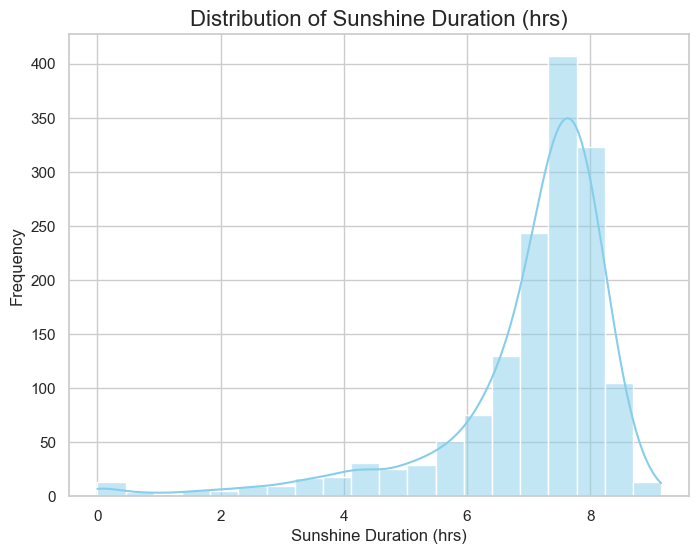

In [8]:
# Sunshine Duration (hrs)
plt.figure(figsize=(8, 6))
sns.histplot(weather_df['Sunshine Duration (hrs)'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sunshine Duration (hrs)', fontsize=16)
plt.xlabel('Sunshine Duration (hrs)')
plt.ylabel('Frequency')
plt.show()

**Sunshine Duration (hrs)**

The distribution of sunshine duration is right-skewed, meaning that most days have a relatively high number of sunshine hours and some days with significantly fewer hours of sunshine. This is further supported by the majority of the data points are clustered around 6 to 8 hours, and the frequency decreases as the sunshine duration approaches 0.

With the mode around 7 hours, it suggests consistent sunlight exposure during the day.

There is a noticeable tail on the left side of the distribution. This indicates that there are some days with very little sunshine, but they are relatively infrequent.

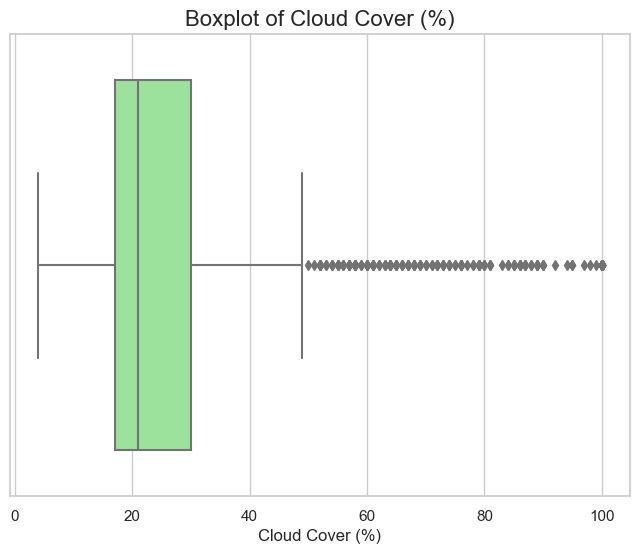

In [9]:
# Cloud Cover (%)
plt.figure(figsize=(8, 6))
sns.boxplot(x=weather_df['Cloud Cover (%)'], color='lightgreen')
plt.title('Boxplot of Cloud Cover (%)', fontsize=16)
plt.xlabel('Cloud Cover (%)')
plt.show()

**Cloud Cover (%)**

The median cloud cover is around 21%, meaning half of the days have cloud cover below 21% and half above.

The interquartile range (IQR) is between 17% and 30%, indicating that the majority of the days experience low to moderate cloud cover.

There are a significant number of outliers beyond the 75th percentile, extending towards 100%. These outliers represent days with unusually high cloud cover, potentially reducing solar efficiency.

The whiskers extend from around 4% to 50%, showing that while extreme cloud cover is uncommon, it is still present in the outliers.

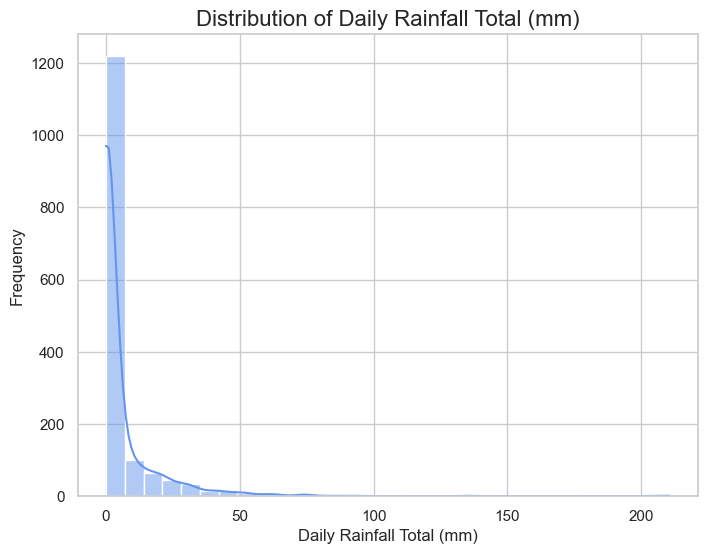

In [10]:
# Daily Total Rainfall (mm)
plt.figure(figsize=(8, 6))
sns.histplot(weather_df['Daily Rainfall Total (mm)'], bins=30, kde=True, color='cornflowerblue')
plt.title('Distribution of Daily Rainfall Total (mm)', fontsize=16)
plt.xlabel('Daily Rainfall Total (mm)')
plt.ylabel('Frequency')
plt.show()

**Daily Total Rainfall (mm)**

The distribution is heavily right-skewed, with the majority of days having little to no rainfall. This is further supported by the mode of the distribution lying near 0 mm. Most data points are clustered around 0–10 mm, and rainfall events beyond 50 mm are rare.

There is a long tail extending towards higher rainfall amounts, indicating a few extreme rainfall events where rainfall totals exceed 100 mm.

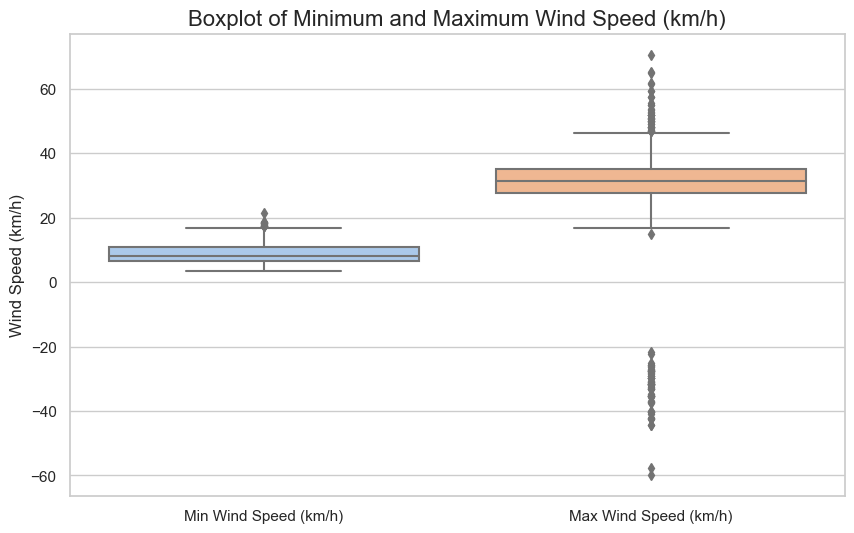

In [11]:
# Wind Speed (Min/Max km/h)
plt.figure(figsize=(10, 6))
sns.boxplot(data=weather_df[['Min Wind Speed (km/h)', 'Max Wind Speed (km/h)']], palette='pastel')
plt.title('Boxplot of Minimum and Maximum Wind Speed (km/h)', fontsize=16)
plt.ylabel('Wind Speed (km/h)')
plt.xticks([0, 1], ['Min Wind Speed (km/h)', 'Max Wind Speed (km/h)'])
plt.show()

**Wind Speed (Min/Max km/h)**

The median minimum wind speed is around 8 km/h, indicating that half of the minimum wind speeds are below this value. The IQR is between approximately 6 km/h and 11 km/h, but it is difficult to determine the exact bounds from the chart alone. This range suggests that most days experience light minimum wind speeds.

The median maximum wind speed is around 32 km/h, meaning half of the maximum wind speeds are below this value.
The IQR appears to be between approximately 28 km/h and 35 km/h, indicating that most days have moderate maximum wind speeds. There are numerous outliers, with some minimum wind speeds reaching negative values (as low as -60 km/h), which are likely data entry errors or might require further investigation.

The smaller whiskers for minimum wind speed indicate that the range of minimum wind speeds is more narrow and concentrated around a smaller set of values. This suggests that the minimum wind speeds across different days tend to be relatively consistent, with less variability.

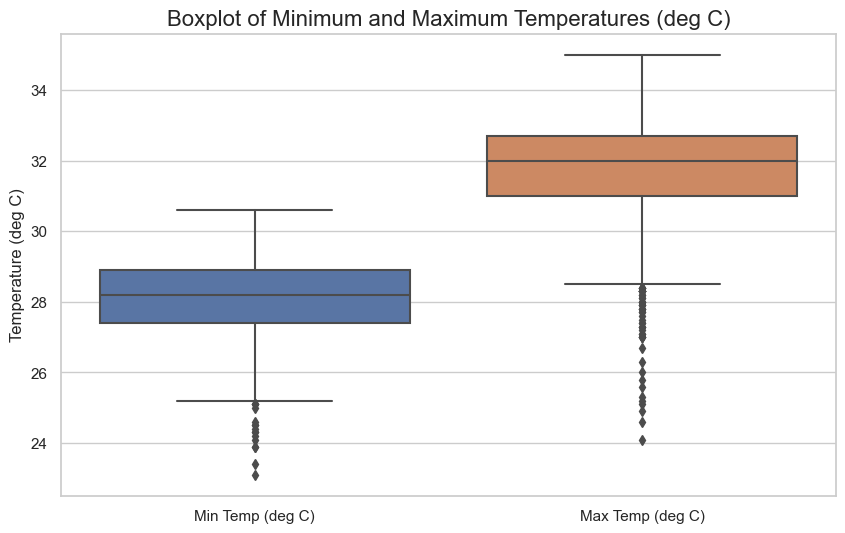

In [12]:
# Maximum and Minimum Temperatures (deg C)
plt.figure(figsize=(10, 6))
sns.boxplot(data=weather_df[['Min Temperature (deg C)', 'Maximum Temperature (deg C)']])
plt.title('Boxplot of Minimum and Maximum Temperatures (deg C)', fontsize=16)
plt.ylabel('Temperature (deg C)')
plt.xticks([0, 1], ['Min Temp (deg C)', 'Max Temp (deg C)'])
plt.show()

**Maximum and Minimum Temperatures (deg C)**

The median minimum temperature is around 28°C, indicating that half of the minimum temperatures are below this value. The IQR appears to be between approximately 27.4°C and 28.9°C, suggesting that the daily minimum temperatures generally fall within this range, with relatively moderate variability. However, there are several outliers below the lower whisker, with temperatures dropping as low as 24°C, which are likely to occur during specific cooler days.

The median maximum temperature is around 32°C, meaning that half of the maximum temperatures are below this value. The IQR appears to be between approximately 31.0°C and 32.7°C, indicating that most days have relatively warm maximum temperatures with less variability. There are also some outliers below the lower whisker, with temperatures going down to about 24°C, suggesting occasional cooler days or possibly measurement issues.

The whiskers for maximum temperature are around the same, suggesting that maximum and minimum temperatures exhibit similar variability.

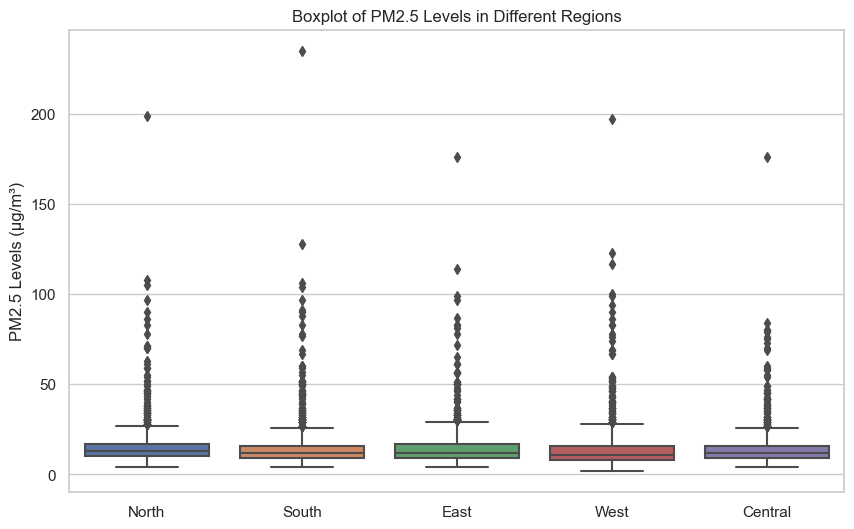

In [13]:
# PM2.5 Levels
plt.figure(figsize=(10, 6))
sns.boxplot(data=air_quality_df[['pm25_north', 'pm25_south', 'pm25_east', 'pm25_west', 'pm25_central']])
plt.title('Boxplot of PM2.5 Levels in Different Regions')
plt.ylabel('PM2.5 Levels (µg/m³)')
plt.xticks([0, 1, 2, 3, 4], ['North', 'South', 'East', 'West', 'Central'])
plt.show()

**PM2.5 Levels**

PM2.5 levels across all regions show similar medians, indicating consistent air quality across regions.

The IQR across all regions are relatively narrow suggesting that most days have fairly consistent PM2.5 levels.

There are significant outliers in all regions, particularly in the North, South and West, where PM2.5 levels go as high as almost 250 µg/m³. These outliers likely represent days with extremely poor air quality, which may greatly affect solar panel efficiency due to reduced sunlight.

In sum, PM2.5 levels are mostly low to moderate across regions, but the occasional extreme pollution days may need special consideration in terms of their impact on solar power generation.

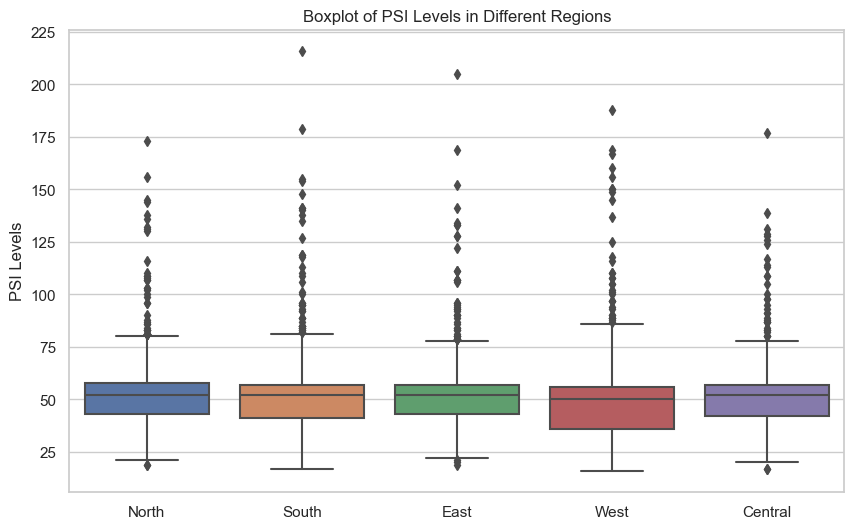

In [14]:
# PSI Levels
plt.figure(figsize=(10, 6))
sns.boxplot(data=air_quality_df[['psi_north', 'psi_south', 'psi_east', 'psi_west', 'psi_central']])
plt.title('Boxplot of PSI Levels in Different Regions')
plt.ylabel('PSI Levels')
plt.xticks([0, 1, 2, 3, 4], ['North', 'South', 'East', 'West', 'Central'])
plt.show()

**PSI Levels**

PSI levels are fairly consistent across all regions, with medians around 50 PSI, indicating moderate pollution levels across the regions.

Similar to PM2.5, the IQR is relatively small, meaning most PSI levels are within a stable range across the regions.

There are a substantial number of outliers where PSI levels can go up to 225 PSI, indicating days with very poor air quality (Very Unhealthy in the PSI index). These outliers represent extreme pollution events that could reduce solar efficiency.

In all, PSI levels remain moderate across the regions, but occasional high-pollution days could negatively impact solar panel performance.

## Multivariate Analysis

In this section, I will conduct multivariate data graphical analysis to investigate the relationship relationships between multiple variables. This will help us understand how different weather and air quality factors interact with one another, and how they influence solar panel efficiency.

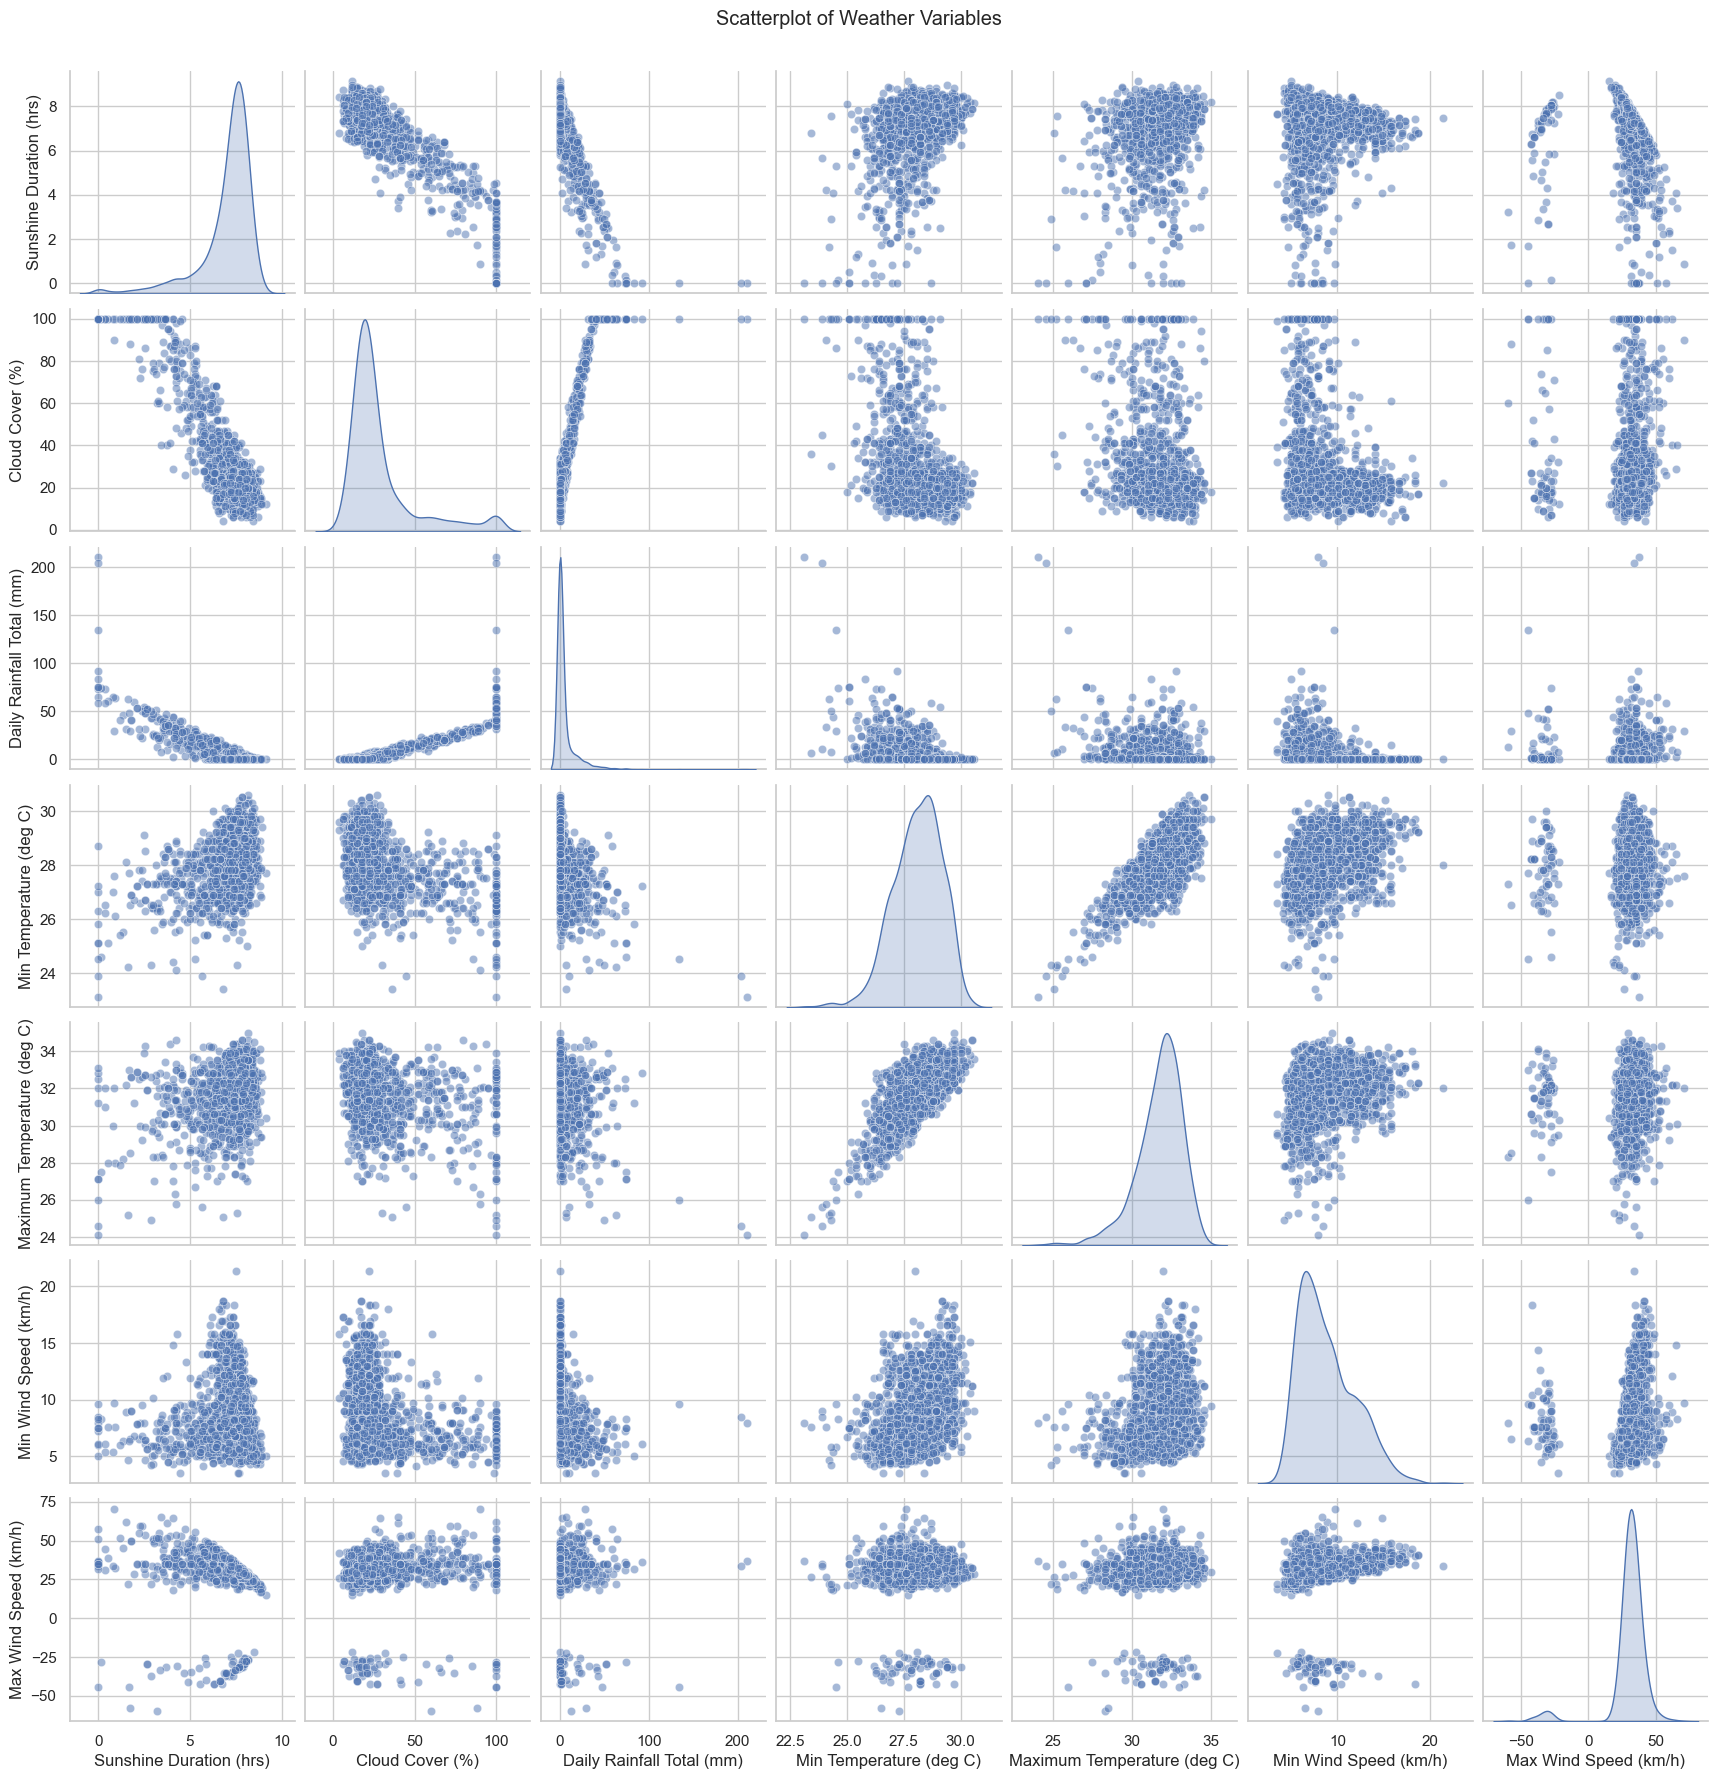

In [15]:
# Selecting relevant continuous variables from weather data
selected_weather_data = weather_df[['Sunshine Duration (hrs)', 
                                    'Cloud Cover (%)', 
                                    'Daily Rainfall Total (mm)',
                                    'Min Temperature (deg C)', 
                                    'Maximum Temperature (deg C)', 
                                    'Min Wind Speed (km/h)',
                                    'Max Wind Speed (km/h)']]

# Plot data
sns.pairplot(selected_weather_data, diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Scatterplot of Weather Variables', y=1.02)
plt.show()

### Scatterplot Matrix

A scatterplot allows us to visualise the relationships between continuous variables in a dataset to see which set of variables are correlated to each other and detect potential outliers.

Here are some findings gathered from the pairplot:

- Clear negative correlation between `Sunshine Duration (hrs)` and `Cloud Cover (%)`. As cloud cover increases, sunshine duration decreases. This makes sense since more clouds would block sunlight, reducing solar panel efficiency.
- Slight negative correlation between `Sunshine Duration (hrs)` and `Daily Rainfall Total (mm)`, meaning that days with more rainfall generally have lower sunshine duration, but it's not as strong as the relationship with cloud cover. This is likely because cloudy days may or may not always be rainy.
- Strong positive correlation between `Cloud Cover (%)` and `Daily Rainfall Total (mm)`. Days with higher cloud cover tend to have more rainfall, as clouds are generally associated with rain.
- There is a positive linear correlation between `Min Temperature` and `Maximum Temperature`, which is expected. When the minimum temperature rises, the maximum temperature tends to rise as well, showing a consistent daily temperature range.

The strongest relationship in the is between Sunshine Duration and Cloud Cover. As cloud cover increases, sunshine hours drop sharply, which is critical for understanding solar panel efficiency. These relationships will have a significant impact on the regression models in Task 2. In particular, the strong negative correlation between `Cloud Cover` and `Sunshine Duration` suggests a potential confounding effect. When modeling the impact of `Sunshine Duration` on solar panel efficiency, it will be important to account for the influence of `Cloud Cover`. Failing to do so could lead to biased estimates of the effect of sunshine duration on solar output. Additionally, variables like `Daily Rainfall` and `Temperature` may also need to be considered, as they influence solar efficiency both directly and indirectly.

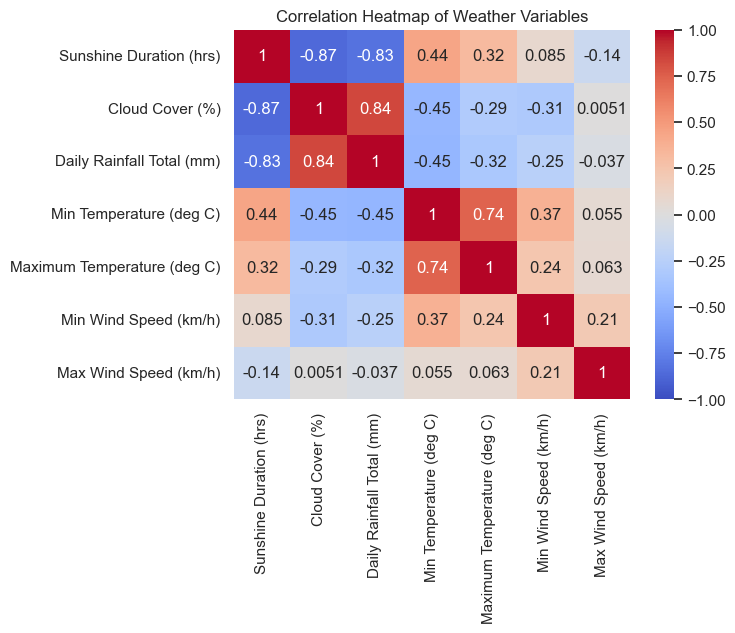

In [16]:
# Calculating correlation matrix for weather data
corr_matrix = selected_weather_data.corr()

# Plotting heatmap of correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Weather Variables')
plt.show()

### Heatmap

The heatmap quantifies the relationships that were visually inferred from the scatterplot matrix. For example, the exact strength of the negative correlation between Sunshine Duration and Cloud Cover (-0.87) and the positive correlation between Cloud Cover and Daily Rainfall (0.84) can be easily identified.

`Sunshine Duration` is strongly influenced by `Cloud Cover` and `Daily Rainfall Total`, as shown by the high absolute correlation values. These relationships will need to be factored into regression models, as both could confound the effect of `Sunshine Duration` on solar output.

The heatmap also highlights weaker relationships, such as those involving wind speed, which may not be as important for predicting solar panel efficiency. These variables could either be excluded from the model or treated with less emphasis.

## Conclusion

This EDA provided valuable insights into the dataset, particularly in understanding the relationships between weather variables that influence solar panel efficiency. The findings from the univariate and multivariate analysis will be instrumental in guiding Task 2 of the project.